In [63]:
import pandas as pd
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt
from nltk import pos_tag
from nltk.stem import PorterStemmer
lm = WordNetLemmatizer()

In [64]:
movie = pd.read_csv('imdb_labelled.txt', delimiter = '\t', names=["reviews", "rating"])
movie.head(10)

,reviews,rating
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
5,"The rest of the movie lacks art, charm, meanin...",0
6,Wasted two hours.,0
7,Saw the movie today and thought it was a good ...,1
8,A bit predictable.,0
9,Loved the casting of Jimmy Buffet as the scien...,1


In [65]:
movie['labels'] = movie["rating"].apply(lambda x: "Positive" if x else "Negative")
movie.head() 

,reviews,rating,labels
0,"A very, very, very slow-moving, aimless movie ...",0,Negative
1,Not sure who was more lost - the flat characte...,0,Negative
2,Attempting artiness with black & white and cle...,0,Negative
3,Very little music or anything to speak of.,0,Negative
4,The best scene in the movie was when Gerardo i...,1,Positive


In [66]:
movie.isna().sum()

reviews    0
rating     0
labels     0
dtype: int64

In [67]:
movie['length'] = movie['reviews'].apply(lambda x: len(str(x).split(' ')))
movie.head()

,reviews,rating,labels,length
0,"A very, very, very slow-moving, aimless movie ...",0,Negative,15
1,Not sure who was more lost - the flat characte...,0,Negative,21
2,Attempting artiness with black & white and cle...,0,Negative,33
3,Very little music or anything to speak of.,0,Negative,10
4,The best scene in the movie was when Gerardo i...,1,Positive,23


In [68]:
movie['length'].unique()

array([  15,   21,   33,   10,   23,   22,    5,   17,   12,    8,   13,
          6,   18,   25,   19,  868,   14,   16,    9,    7,   26,   35,
         11,    4,   27,   28,    3,   20,   37,   24,   36,  201, 1393,
         49,   30,  306,   31,   32,   44,   56,   45,   34,   38,   64,
         58,   40,   47,   29,   73,   41,   39,   55,   53,   42,  800])

<BarContainer object of 55 artists>

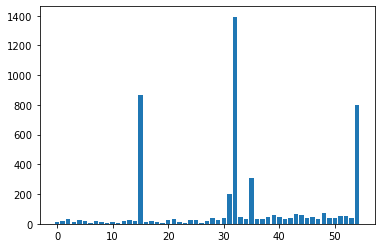

In [69]:
unique_lengths = movie['length'].unique()
plt.bar(np.arange(len(unique_lengths)), unique_lengths)

In [70]:
X = movie['reviews']
y = movie['rating']

In [71]:
stemmerizer = PorterStemmer()
word_lemm = WordNetLemmatizer()

In [72]:
for word in X:
    rootword = stemmerizer.stem(word)

In [73]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(rootword)

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.is_alpha, token.is_stop)

all all DET DT ROOT True True
in in ADP IN prep True True
all all DET DT predet True True
its -PRON- DET PRP$ poss True True
an an DET DT det True True
insult insult NOUN NN pobj True False
to to ADP IN prep True True
one one NOUN NN poss True True
's 's PART POS case False True
intelligence intelligence NOUN NN pobj True False
and and CCONJ CC cc True True
a a DET DT det True True
huge huge ADJ JJ amod True False
waste waste NOUN NN conj True False
of of ADP IN prep True True
money money NOUN NN pobj True False
. . PUNCT . punct False False
    SPACE _SP  False False


In [74]:
token, X_test, y_train, y_test = train_test_split(X,y, test_size = .40, random_state = 60)

In [75]:
token.shape, token.to_list()[:4]

((448,),
 ['I am so tired of clichés that is just lazy writing, and here they come in thick and fast.  ',
  'Nothing short of magnificent photography/cinematography in this film.  ',
  'The acting was bad, the dialogs were extremely shallow and insincere.  ',
  "The soundtrack wasn't terrible, either.  "])

In [76]:
from sklearn.preprocessing import OrdinalEncoder

vectorizer = CountVectorizer(stop_words = 'english')
vectorizer.fit(token)


X_train_transform = (vectorizer.transform(token).toarray() > 0).astype(int)
X_test_transform = (vectorizer.transform(X_test).toarray() > 0).astype(int)

print("X_test_transform shape = ", X_test_transform.shape)
print("X_train_transform shape = ", X_train_transform.shape)

X_test_transform shape =  (300, 1888)
X_train_transform shape =  (448, 1888)


In [77]:
np.unique(X_test_transform)

array([0, 1])

In [78]:
nb = CategoricalNB()
nb.fit(X_train_transform, y_train)

train_accuracy = nb.score(X_train_transform, y_train)
print(f"Training accuracy is {train_accuracy*100:.2f}%")

Training accuracy is 94.20%


In [79]:
np.unique(X_test_transform)

array([0, 1])

In [80]:
test_accuracy = nb.score(X_test_transform, y_test.values)

print(f"Testing accuracy is {test_accuracy*100:.2f}%")

Testing accuracy is 75.67%


In [81]:
from sklearn.metrics import classification_report, confusion_matrix

y_predicted = nb.predict(X_test_transform)
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.70      0.94      0.80       155
           1       0.89      0.57      0.69       145

    accuracy                           0.76       300
   macro avg       0.79      0.75      0.75       300
weighted avg       0.79      0.76      0.75       300



In [82]:
pd.DataFrame(data=confusion_matrix(y_test, y_predicted, labels=[1, 0]), index=[1, 0], columns=[1, 0])

,1,0
1,82,63
0,10,145


In [83]:
accurancy = []

stratified_predict = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)
stratified_predict.get_n_splits(X_train_transform, y_train)

for train_index, test_index in stratified_predict.split(X, y):

    X1_train, X1_test = X.iloc[train_index], X.iloc[test_index]
    Y1_train, Y1_train = y.iloc[train_index], y.iloc[test_index]
    
    vectorizer.fit(X1_train, Y1_train)
    result = vectorizer.score(X1_test, Y1_test)
    accurancy.append(result)
  
    



AttributeError: 'CountVectorizer' object has no attribute 'score'